Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best Model Evaluation:
Mean Squared Error (MSE): 0.6499392235123375
Mean Absolute Error (MAE): 0.3940856313497804
R2 Score: 0.999980001267236
Most Important Features:
Index(['month', 'day', 'product_800mm BBQ', 'price',
       'product_Gas Hob (2 burners)', 'product_1000mm BBQ',
       'product_600mm BBQ', 'promotion', 'product_Gas Hob (1 burner)',
       'day_of_week_Monday'],
      dtype='object')


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Cross-Validation RMSE: 0.5904737833506102


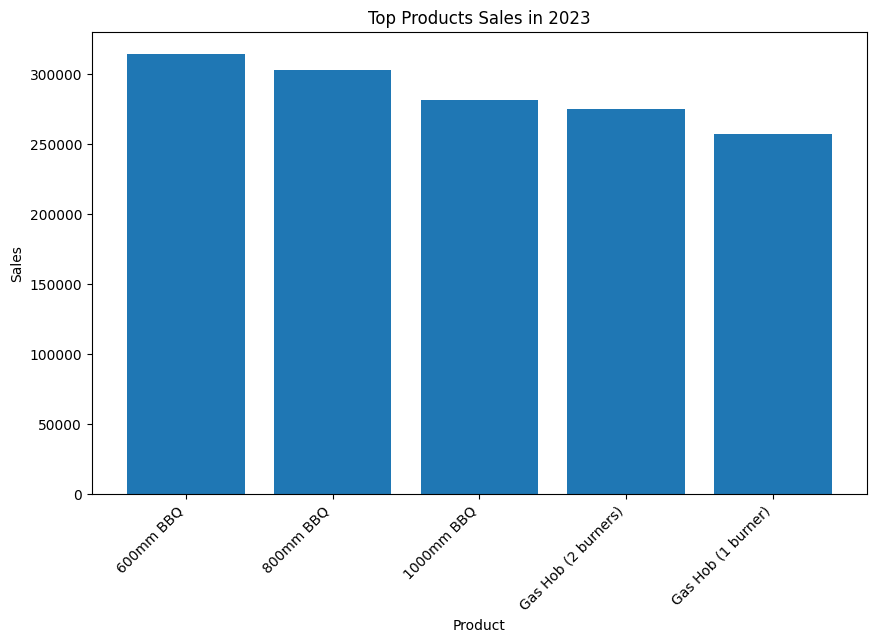

Top Products Sales in 2023:
600mm BBQ: 314350
800mm BBQ: 302710
1000mm BBQ: 281105
Gas Hob (2 burners): 274485
Gas Hob (1 burner): 256800


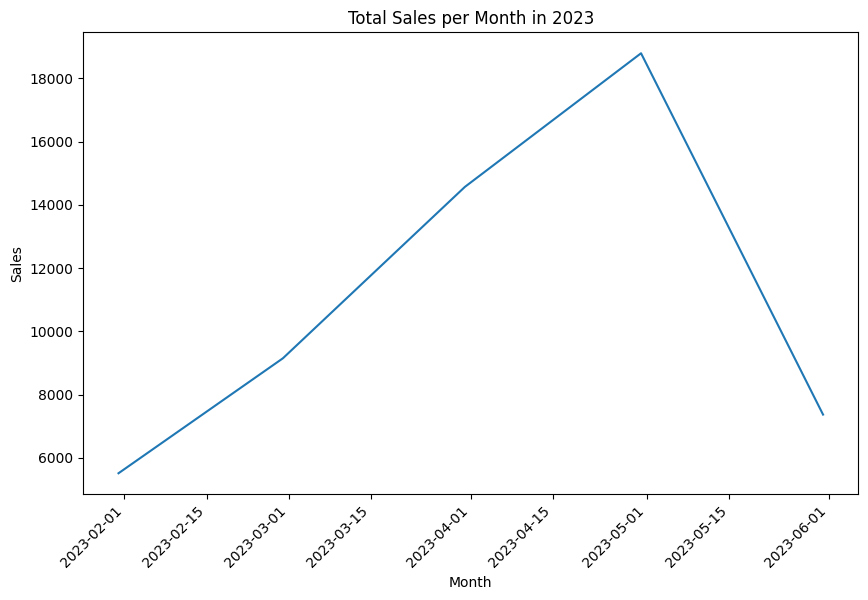

Monthly Sales in 2023:
January 2023: 5515.0
February 2023: 9150.0
March 2023: 14570.0
April 2023: 18795.0
May 2023: 7370.0


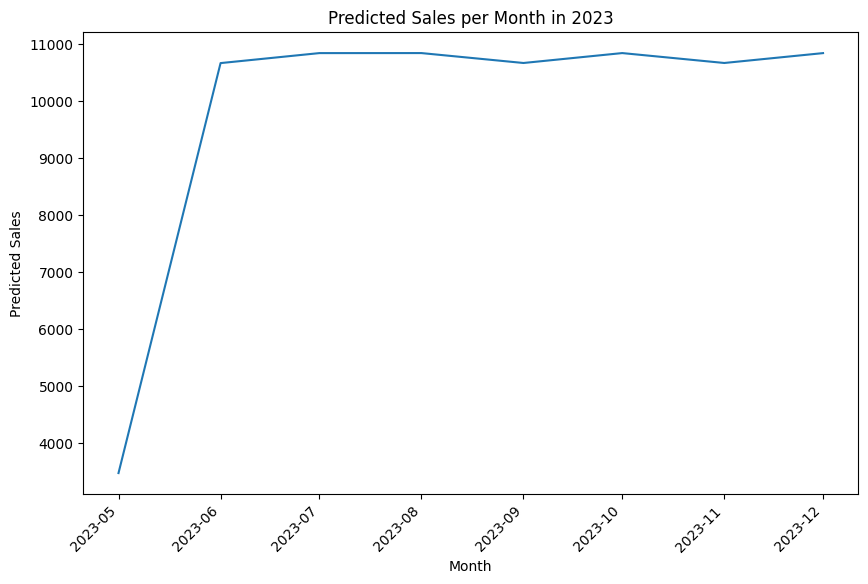

Predicted Monthly Sales in 2023:
May 2023: 3473.45
June 2023: 10665.9
July 2023: 10841.075
August 2023: 10841.625
September 2023: 10667.75
October 2023: 10841.55
November 2023: 10667.9
December 2023: 10840.95


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("/Users/lucianosouza/Desktop/ml_sales_prediction/new_data.csv")

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.day_name()

# Separate features and target variable
X = data[['year', 'month', 'day', 'day_of_week', 'price', 'promotion', 'product']]
y = data['quantity_sold']

# Encode categorical features and standardize the features
X_encoded = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform grid search cross-validation for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1)

grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Train the best model with the training dataset
best_model.fit(X_train, y_train)

# Evaluate the best model on the testing dataset
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2 Score:", r2)

# Get the feature importances from the best model
feature_importances = best_model.feature_importances_

# Get the indices of the most important features
most_important_indices = np.argsort(feature_importances)[::-1][:10]

# Get the names of the most important features
most_important_features = X_encoded.columns[most_important_indices]

print("Most Important Features:")
print(most_important_features)

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Get the average RMSE across the cross-validation folds
cv_rmse = np.sqrt(-cv_scores.mean())

print("Cross-Validation RMSE:", cv_rmse)

# Get the products with the biggest sales in 2023
top_products_2023 = data.groupby('product')['quantity_sold'].sum().nlargest(5)
top_products_2023_list = top_products_2023.index.tolist()
top_products_2023_quantities = top_products_2023.values.tolist()

# Filter the data for the top products in 2023
top_products_data_2023 = data[data['product'].isin(top_products_2023_list)]

# Group the data by date and product and calculate the sum of quantity sold
product_sales_2023 = top_products_data_2023.groupby(['date', 'product'])['quantity_sold'].sum().reset_index()

# Pivot the data to have dates as rows and products as columns
product_sales_pivot_2023 = product_sales_2023.pivot(index='date', columns='product', values='quantity_sold')

# Filter sales data for 2023
sales_2023 = product_sales_pivot_2023[product_sales_pivot_2023.index.year == 2023]

# Group by product and calculate total sales
product_sales_2023 = sales_2023.groupby(axis=1, level=0).sum()

# Sort the products based on sales
sorted_products_2023 = product_sales_2023.sum().sort_values(ascending=False)

# Plot the top products in 2023
plt.figure(figsize=(10, 6))
plt.bar(top_products_2023_list, top_products_2023_quantities)
plt.xlabel('Product')
plt.ylabel('Sales')
plt.title('Top Products Sales in 2023')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the list of top products sales in 2023
print("Top Products Sales in 2023:")
for product, sales in zip(top_products_2023_list, top_products_2023_quantities):
    print(f"{product}: {sales}")

# Group by month and calculate total sales for each product
product_sales_2023_monthly = sales_2023.resample('M').sum()

# Calculate the sum of sales across all products for each month
total_sales_2023 = product_sales_2023_monthly.sum(axis=1)

# Plot total sales per month in 2023
plt.figure(figsize=(10, 6))
plt.plot(total_sales_2023.index, total_sales_2023.values)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Total Sales per Month in 2023')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print list of total sales per month in 2023
print("Monthly Sales in 2023:")
for month, sales in total_sales_2023.items():
    print(f"{month.strftime('%B %Y')}: {sales}")

# Generate predictions for the future period
start_date = sales_2023.index.max() + pd.DateOffset(days=1)
end_date = date(2023, 12, 31)
future_dates = pd.date_range(start_date, end_date, freq='D')
future_data = pd.DataFrame({'date': future_dates})
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day'] = future_data['date'].dt.day
future_data['day_of_week'] = future_data['date'].dt.day_name()
future_data['price'] = 0
future_data['promotion'] = 0
future_data['product'] = 'Product A'

# Encode categorical features and standardize the features
future_data_encoded = pd.get_dummies(future_data)
future_data_encoded = future_data_encoded.reindex(columns=X_encoded.columns, fill_value=0)  # Align columns
future_data_scaled = scaler.transform(future_data_encoded)

# Generate predictions for the future period using the best model
future_predictions = best_model.predict(future_data_scaled)

# Create a dataframe for the predictions
predictions = pd.DataFrame(future_data_encoded, columns=X_encoded.columns)
predictions['quantity_sold'] = future_predictions

# Group the predicted sales by date and calculate the total sales per month
predictions_monthly_sales = predictions.groupby(['year', 'month'])['quantity_sold'].sum().reset_index()

# Create a datetime column for the predictions
predictions_monthly_sales['date'] = pd.to_datetime(predictions_monthly_sales[['year', 'month']].assign(day=1))

# Plot the predicted sales per month in 2023
plt.figure(figsize=(10, 6))
plt.plot(predictions_monthly_sales['date'], predictions_monthly_sales['quantity_sold'])
plt.xlabel('Month')
plt.ylabel('Predicted Sales')
plt.title('Predicted Sales per Month in 2023')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print list of predicted sales per month in 2023
print("Predicted Monthly Sales in 2023:")
for month, sales in zip(predictions_monthly_sales['date'], predictions_monthly_sales['quantity_sold']):
    print(f"{month.strftime('%B %Y')}: {sales}")
